# Transfer learning simplified example with CIFAR-10 dataset
### Dr. Tirthajyoti Sarkar, Fremont, CA ([LinkedIn](https://www.linkedin.com/in/tirthajyoti-sarkar-2127aa7/), [Github](https://tirthajyoti.github.io))

For more tutorial-style notebooks on deep learning, **[here is my Github repo](https://github.com/tirthajyoti/Deep-learning-with-Python)**.

For more tutorial-style notebooks on general machine learning, **[here is my Github repo](https://github.com/tirthajyoti/Machine-Learning-with-Python)**.

---

## What is transfer learning?

**Deep learning networks tend to be resource hungry and computationally expensive**. Unlike traditional statistical learning models (such as regression, decision trees, or support vector machines), they tend to contain millions of parameters and therefore need a lot of training data to avoid overfitting.

Therefore, deep learning models are trained with massive amounts of high-dimensional raw data such as images, unstructured text, or audio signals. Also, they employ millions of of vectorized computation (e.g. matrix multiplication) over and over, to optimize the huge parameter set to fit to the data. All of these lead to a great demand on the computational power needed to train and robust and high-performance deep learning model for a given task. 

Let’s say we can afford to train a great model after spending a huge amount of computational resources. Don’t we want to re-use this model for the maximum number of tasks and reap the benefit of our investment many times over?

> But, here is the problem.

**Deep learning algorithms, so far, have been traditionally designed to work in isolation**. These algorithms are trained to solve specific tasks. The models, in most cases, have to be rebuilt from scratch once the feature-space distribution changes.

> But, this does not make sense, especially if compared to how we humans utilize our limited computation speed.

**Humans have an inherent ability to transfer knowledge across tasks**. What we acquire as knowledge while learning about one task, we utilize in the same way to solve related tasks. If the similarity between the tasks or domains is high, we are able to cross-utilize our ‘learned’ knowledge better.

> ***Transfer learning is the idea of overcoming the isolated learning paradigm and utilizing knowledge acquired for one task to solve related ones, as applied to machine learning, and in particular, to the domain of deep learning.***

![transfer-learning](https://raw.githubusercontent.com/tirthajyoti/Deep-learning-with-Python/master/images/Transfer_learning.jpeg)

---

## Demonstrate transfer learning with a simple example
### A common strategy
There are a myriad of strategies to follow for transfer learning process in the deep learning setting, and multiple important things to consider and engineering decisions to make - similarity of datasets and domains, supervised or unsupervised setting, how much retraining to be done, etc.
However, to put it very simply, we can assume that for transfer learning, 
- we need to take a pre-trained deep learning model, 
- re-use all or certain portions of this, and 
- apply it to our new domain of interest, for a particular machine learning problem - classification or regression.

In this way, we are able to avoid a large portion of the huge computational effort of training and optimizing a large deep learning model. 

At the end, a trained deep learning model is just a collection of millions of real numbers in a particular data structure format, which can be used readily for prediction/inference, the task we are really interested in, as the consumers of the model.

But remember that a pre-trained model might have been trained using a particular classification in mind i.e. its output vector and computation graph is suited for prediction of a particular task only.

Therefore, a widely used strategy in transfer learning is to,

- load the weights matrices of a pre-trained model except for the weights of the very last layers near the O/P,
- hold those weights fixed i.e. untrainable
- attach new layers suitable for the task at hand, and train the model with new data

![TL-DL](https://raw.githubusercontent.com/tirthajyoti/Deep-learning-with-Python/master/images/Transfer-learning-DL-1.png)

### This demo
We demonstrate the essential concept of transfer Learning in a very simple setting.

We take the well-known CIFAR-10 dataset and do the following, 

- Create a Keras neural net by stacking a set of `classificiation_layers` on top of a set of `feature_layers` 
- Train the resulting network on a partial CIFAR-10 dataset, consisting of examples from the first 5 categories (0...4).
- Freeze the `feature_layers` and stack a new set of fully-connected layers on top of them, thereby creating another conv net 
- Train this new conv net on the examples from the rest of the categories (5..9) of CIFAR-10, tuning weights only for those densely connected layers

## Let's code along
### Import libraries and functions

In [1]:
from __future__ import print_function

from time import time
import keras
from keras.datasets import mnist,cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras import backend as K

import matplotlib.pyplot as plt
import random

Using TensorFlow backend.


### Filters, pool size, and kernel size

In [2]:
# number of convolutional filters to use
filters = 64
# size of pooling area for max pooling
pool_size = 2
# convolution kernel size
kernel_size = 3

### Load and split the data between train and test sets

In [3]:
(x_cifar_train, y_cifar_train), (x_cifar_test, y_cifar_test) = cifar10.load_data()

In [4]:
y_cifar_train = y_cifar_train.reshape(50000,)
y_cifar_test = y_cifar_test.reshape(10000,)

### Create two datasets one with class labels below 5 and one with 5 and above

In [5]:
x_train_lt5 = x_cifar_train[y_cifar_train < 5]
y_train_lt5 = y_cifar_train[y_cifar_train < 5]
x_test_lt5 = x_cifar_test[y_cifar_test < 5]
y_test_lt5 = y_cifar_test[y_cifar_test < 5]

x_train_gte5 = x_cifar_train[y_cifar_train >= 5]
y_train_gte5 = y_cifar_train[y_cifar_train >= 5] - 5
x_test_gte5 = x_cifar_test[y_cifar_test >= 5]
y_test_gte5 = y_cifar_test[y_cifar_test >= 5] - 5

### Let's see some examples from the two data sets to understand what's going on.

Here is the description of the categories in the CIFAR-10 dataset,

![cifar-10](https://raw.githubusercontent.com/tirthajyoti/Deep-learning-with-Python/master/images/CIFAR-10-categories.PNG)

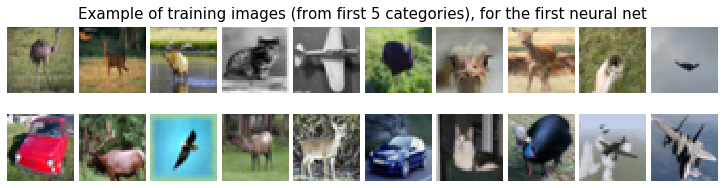

In [6]:
fig, ax = plt.subplots(2,10,figsize=(10,2.8))
fig.suptitle("Example of training images (from first 5 categories), for the first neural net\n", fontsize=15)
axes = ax.ravel()
for i in range(20):
    # Pick a random number
    idx=random.randint(1,1000)
    axes[i].imshow(x_train_lt5[idx])
    axes[i].axis('off')
fig.tight_layout(pad=0.5)
plt.show()

We can run the cell above multiple times, pick up random indices and show the images but since we are picking up images from the `x_train_lt5` dataset, we will only see images of either **airplane, automobile, bird, cat,** or **deer**.

And that's what the neural network will also 'see'.

However, when we transfer the learning to a new neural network, its output layers will be tuned on a new dataset consisting of images of either **dog, frog, horse, sheep, or truck**.

But we will see that it will do just fine :-)

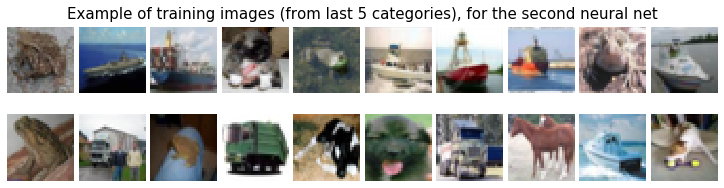

In [7]:
fig, ax = plt.subplots(2,10,figsize=(10,2.8))
fig.suptitle("Example of training images (from last 5 categories), for the second neural net\n", fontsize=15)
axes = ax.ravel()
for i in range(20):
    # Pick a random number
    idx=random.randint(1,1000)
    axes[i].imshow(x_train_gte5[idx])
    axes[i].axis('off')
fig.tight_layout(pad=0.5)
plt.show()

### Set the number of classes and the input shape

In [8]:
num_classes = 5
input_shape = (32,32,3)

### Define two groups of layers: feature (convolutions) and classification (dense)

In [9]:
feature_layers = [
    Conv2D(filters, kernel_size,
           padding='valid',
           input_shape=input_shape),
    Activation('relu'),
    Conv2D(filters, kernel_size),
    Activation('relu'),
    MaxPooling2D(pool_size=pool_size),
    Dropout(0.25),
    Flatten(),
]

In [10]:
classification_layers = [
    Dense(128),
    Activation('relu'),
    Dropout(0.25),
    Dense(num_classes),
    Activation('softmax')
]

### Create the complete model by stacking together `feature_layers` and `classification_layers`

In [11]:
model_1 = Sequential(feature_layers + classification_layers)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


### Function definition for training a model

In [12]:
def train_model(model, train, test, num_classes):
    x_train = train[0].reshape((train[0].shape[0],) + input_shape)
    x_test = test[0].reshape((test[0].shape[0],) + input_shape)
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255
    print('x_train shape:', x_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')

    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(train[1], num_classes)
    y_test = keras.utils.to_categorical(test[1], num_classes)

    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(lr=0.001),
                  metrics=['accuracy'])

    t1 = time()
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(x_test, y_test))
    t2 = time()
    t_delta = round(t2-t1,2)
    print('Training time: {} seconds'.format(t_delta))
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test score:', score[0])
    print('Test accuracy:', score[1])

### Batch size and epochs

In [13]:
batch_size = 128
epochs = 20

### Train model for the first 5 categories of images

In [14]:
train_model(model_1,
            (x_train_lt5, y_train_lt5),
            (x_test_lt5, y_test_lt5), num_classes)

x_train shape: (25000, 32, 32, 3)
25000 train samples
5000 test samples
Instructions for updating:
Use tf.cast instead.
Train on 25000 samples, validate on 5000 samples
Epoch 1/20
25000/25000 [==============================] - 7s 300us/step - loss: 1.0676 - acc: 0.5611 - val_loss: 0.8493 - val_acc: 0.6568
Epoch 2/20
25000/25000 [==============================] - 4s 165us/step - loss: 0.8101 - acc: 0.6817 - val_loss: 0.7624 - val_acc: 0.7062
Epoch 3/20
25000/25000 [==============================] - 4s 167us/step - loss: 0.7054 - acc: 0.7301 - val_loss: 0.6821 - val_acc: 0.7382
Epoch 4/20
25000/25000 [==============================] - 4s 167us/step - loss: 0.6346 - acc: 0.7563 - val_loss: 0.6438 - val_acc: 0.7576
Epoch 5/20
25000/25000 [==============================] - 4s 166us/step - loss: 0.5697 - acc: 0.7837 - val_loss: 0.6357 - val_acc: 0.7568
Epoch 6/20
25000/25000 [==============================] - 4s 167us/step - loss: 0.5216 - acc: 0.8039 - val_loss: 0.6452 - val_acc: 0.7604
Epo

Also note the time taken for this training ~ 87 seconds. This will vary depending on your hardware, but keep a note of this time.

### Show the model summary and note that there are no untrainable parameters

In [15]:
model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 64)        1792      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
activation_2 (Activation)    (None, 28, 28, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 12544)             0         
__________

### How the accuracy evolved...

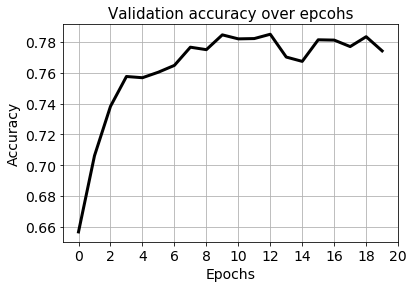

In [19]:
plt.title("Validation accuracy over epcohs",fontsize=15)
plt.plot(model_1.history.history['val_acc'],lw=3,c='k')
plt.grid(True)
plt.xlabel("Epochs",fontsize=14)
plt.ylabel("Accuracy",fontsize=14)
plt.xticks([2*i for i in range(11)],fontsize=14)
plt.yticks(fontsize=14)
plt.show()

### Freeze feature layers and rebuild model
This freezing of feature layers is at the heart of transfer learning. This allows re-use of pre-trained model for classification tasks, because users can just stack up new fully-connected layers on top of the pre-trained feature layers and get good performance.

We will create a fresh new model called `model_2` with the untrainable `feature_layers` and trainable `classification_layers`

In [20]:
for l in feature_layers:
    l.trainable = False

In [21]:
model_2 = Sequential(feature_layers + classification_layers)

### Show the model summary and see that the features layers (Conv2D) have been renderd untrainable now

In [23]:
model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 64)        1792      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
activation_2 (Activation)    (None, 28, 28, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 12544)             0         
__________

### Now train the model and see how it takes less overall time and still gets equal or higher performance (validation accuracy)

In [24]:
# transfer: train dense layers for new classification task
train_model(model_2,
            (x_train_gte5, y_train_gte5),
            (x_test_gte5, y_test_gte5), num_classes)

x_train shape: (25000, 32, 32, 3)
25000 train samples
5000 test samples
Train on 25000 samples, validate on 5000 samples
Epoch 1/20
25000/25000 [==============================] - 3s 134us/step - loss: 1.5506 - acc: 0.4684 - val_loss: 0.8126 - val_acc: 0.7046
Epoch 2/20
25000/25000 [==============================] - 3s 102us/step - loss: 0.8023 - acc: 0.6950 - val_loss: 0.5986 - val_acc: 0.7898
Epoch 3/20
25000/25000 [==============================] - 3s 101us/step - loss: 0.6349 - acc: 0.7686 - val_loss: 0.5234 - val_acc: 0.8104
Epoch 4/20
25000/25000 [==============================] - 3s 101us/step - loss: 0.5420 - acc: 0.7987 - val_loss: 0.4911 - val_acc: 0.8248
Epoch 5/20
25000/25000 [==============================] - 3s 102us/step - loss: 0.4782 - acc: 0.8235 - val_loss: 0.4683 - val_acc: 0.8316
Epoch 6/20
25000/25000 [==============================] - 3s 105us/step - loss: 0.4295 - acc: 0.8418 - val_loss: 0.4515 - val_acc: 0.8340
Epoch 7/20
25000/25000 [===========================

The time taken has reduced significantly to ~ 52 seconds! This is because, we did not train the initial Conv2D layers and only tuned the fully connected layers. But the accuracy is pretty good.

### Plot the accuracy

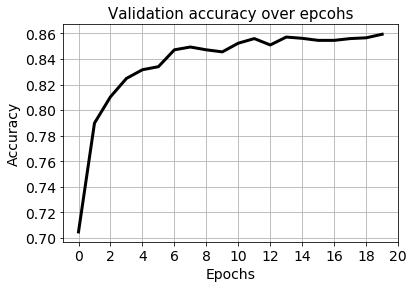

In [25]:
plt.title("Validation accuracy over epcohs",fontsize=15)
plt.plot(model_2.history.history['val_acc'],lw=3,c='k')
plt.grid(True)
plt.xlabel("Epochs",fontsize=14)
plt.ylabel("Accuracy",fontsize=14)
plt.xticks([2*i for i in range(11)],fontsize=14)
plt.yticks(fontsize=14)
plt.show()

### Time taken by the two models for training (identical number of epochs)

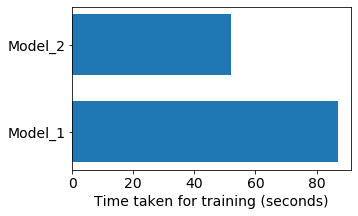

In [35]:
plt.figure(figsize=(5,3))
plt.barh(y=['Model_1','Model_2'],width=[87,52],height=0.7)
plt.xlabel("Time taken for training (seconds)",fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.show()

## Summary
The `model_2` was initialized a fresh model consisting of untrainable Conv2D layers and trainable fully-connected layers. The Conv2D layers' weights were transferred from a previously trained `model_1`.

Not only, did the `model_2` train faster than `model_1`, it also started at a higher baseline accuracy and achieved better final accuracy for the same number of epochs and identical hyperparameters (learning rate, optimizer, batch size, etc.).

And it achieved this training on images which were not seen by `model_1`. **This is the essence of transfer learning.**

This means that although `model_1` was trained on images of - **airplane, automobile, bird, cat, or deer** - it’s learned weights, when transferred to `model_2`, helped `model_2` achieve excellent performance on the classification of completely different categories of images - **dog, frog, horse, sheep, or truck**.

![two-categories](https://raw.githubusercontent.com/tirthajyoti/Deep-learning-with-Python/master/images/transfer-learning-2-categories.png)

***Isn’t this amazing?*** And you can now build this kind of transfer learning with so few lines of codes.
